In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

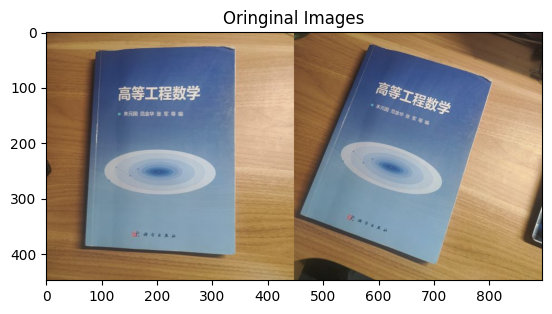

In [2]:
imgA_path, imgB_path = './assets/test1.jpg', './assets/test2.jpg'
imageA, imageB = cv2.imread(imgA_path), cv2.imread(imgB_path)
origin_img = cv2.hconcat([imageA, imageB])
plt.imshow(cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB))
plt.title("Oringinal Images")
plt.show()

# 手动实现特征点的选择和匹配

In [3]:
# 定义鼠标回调函数
def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        # 当按下左键时，获取并打印x，y坐标
        print(f"Mouse coordinates: X={x} Y={y}")

In [4]:
# 创建一个窗口并将鼠标回调函数绑定到该窗口
cv2.namedWindow('imageA')
cv2.setMouseCallback('imageA', click_event)
cv2.imshow('imageA', imageA)
cv2.waitKey(0)
cv2.destroyAllWindows()

Mouse coordinates: X=92 Y=35
Mouse coordinates: X=343 Y=32
Mouse coordinates: X=71 Y=388
Mouse coordinates: X=341 Y=400


In [5]:
# 创建一个窗口并将鼠标回调函数绑定到该窗口
cv2.namedWindow('imageB')
cv2.setMouseCallback('imageB', click_event)
cv2.imshow('imageB', imageB)
cv2.waitKey(0)
cv2.destroyAllWindows()

Mouse coordinates: X=139 Y=23
Mouse coordinates: X=359 Y=91
Mouse coordinates: X=12 Y=330
Mouse coordinates: X=257 Y=419


In [6]:
# 收集手动提取匹配的特征点
ptsA = np.array([[92, 35], [343, 32], [71, 388], [341, 400]])
ptsB = np.array([[139, 23], [359, 91], [12, 330], [257, 419]])

In [7]:
# 计算单适应变换矩阵
H, mask = cv2.findHomography(ptsB, ptsA)
print(H)

[[ 1.01218176e+00  3.62445656e-01 -5.76260403e+01]
 [-3.43351644e-01  1.06420458e+00  5.80222339e+01]
 [-6.91483919e-05  1.35984704e-04  1.00000000e+00]]


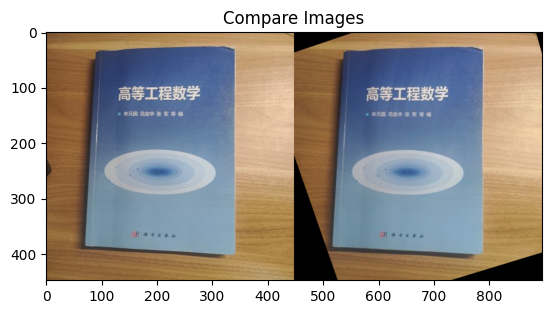

In [8]:
# 对图片B进行单适应变换
imageB_warp = cv2.warpPerspective(imageB, H, (imageA.shape[1], imageA.shape[0]))
compare_img = cv2.hconcat([imageA, imageB_warp])
plt.imshow(cv2.cvtColor(compare_img, cv2.COLOR_BGR2RGB))
plt.title("Compare Images")
plt.show()

# 基于SIFI方法提取特征点

In [9]:
# 计算特征点和特征向量
def detectAndDescribe(image):
    # 转换为灰度图
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 建立SIFT生成器
    descriptor = cv2.SIFT_create()
    # 检测特征点并计算描述子
    kps, features = descriptor.detectAndCompute(gray, None)

    kps = np.float32([kp.pt for kp in kps])

    return kps, features

kpsA, featureA = detectAndDescribe(imageA)
kpsB, featureB = detectAndDescribe(imageB)

In [10]:
# 建立暴力匹配器
matcher = cv2.BFMatcher()

# 使用KNN检测来自A、B图的SIFT特征匹配
rawMatches = matcher.knnMatch(featureA, featureB, 2)

# 过滤
matches = []
for m in rawMatches:
    if len(m) == 2 and m[0].distance < m[1].distance * 0.75:
        matches.append((m[0].trainIdx, m[0].queryIdx))

if len(matches) > 4:
    # 获取匹配对的点坐标
    ptsA = np.float32([kpsA[i] for (_, i) in matches])
    ptsB = np.float32([kpsB[i] for (i, _) in matches])

In [11]:
# 计算单适应变换矩阵
H, mask = cv2.findHomography(ptsB, ptsA, cv2.RANSAC, 4)
print(H)

[[ 1.01405972e+00  3.68072842e-01 -5.84863352e+01]
 [-3.48985914e-01  1.07357938e+00  5.76210225e+01]
 [-7.08132785e-05  1.64302214e-04  1.00000000e+00]]


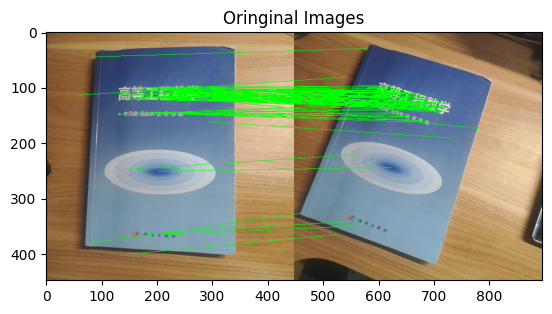

In [12]:
# 匹配结果可视化
def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):
    # 初始化可视化图片，将A、B图左右连接到一起
    hA, wA = imageA.shape[:2]
    hB, wB = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:(wA+wB)] = imageB

    # 联合遍历，画出匹配对
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        # 当点对匹配成功时，画到可视化图上
        if s == 1:
            # 画出匹配对
            ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
            ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
            cv2.line(vis, ptA, ptB, (0, 255, 0), 1)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title("Oringinal Images")
    plt.show()
drawMatches(imageA, imageB, kpsA, kpsB, matches, mask)

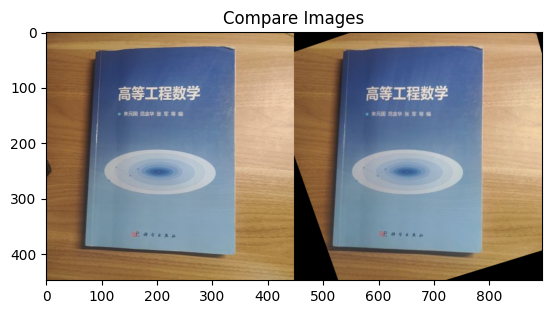

In [13]:
# 对图片B进行单适应变换
imageB_warp = cv2.warpPerspective(imageB, H, (imageA.shape[1], imageA.shape[0]))
compare_img = cv2.hconcat([imageA, imageB_warp])
plt.imshow(cv2.cvtColor(compare_img, cv2.COLOR_BGR2RGB))
plt.title("Compare Images")
plt.show()